# Scenario 1: Root Cause Analysis (Why is fraud happening?)

In [0]:
%sql
-- SCENARIO 1: ROOT CAUSE ANALYSIS
-- We calculate Fraud Rate for different transaction scenarios

SELECT 
    Transaction_Type,
    CASE 
        WHEN Merchant_City = User_City THEN 'Home City'
        ELSE 'Different City'
    END AS Location_Match,
    COUNT(*) as Total_Txns,
    SUM(Anomaly) as Fraud_Cases,
    ROUND(AVG(Anomaly) * 100, 2) as Fraud_Rate_Percent
FROM silver_transactions
GROUP BY 1, 2
ORDER BY Fraud_Rate_Percent DESC;

Transaction_Type,Location_Match,Total_Txns,Fraud_Cases,Fraud_Rate_Percent
Chip,Different City,24425,3009,12.32
Online,Different City,24544,2979,12.14
Swipe,Different City,24417,2963,12.13
Chip,Home City,143033,14205,9.93
Swipe,Home City,141474,13968,9.87
Online,Home City,142107,14012,9.86


In [0]:
%sql
CREATE OR REPLACE VIEW why_fraud_is_happening AS
SELECT 
    Transaction_Type,
    CASE 
        WHEN Merchant_City = User_City THEN 'Home City'
        ELSE 'Different City'
    END AS Location_Match,
    COUNT(*) as Total_Txns,
    SUM(Anomaly) as Fraud_Cases,
    ROUND(AVG(Anomaly) * 100, 2) as Fraud_Rate_Percent
FROM silver_transactions
GROUP BY 1, 2;

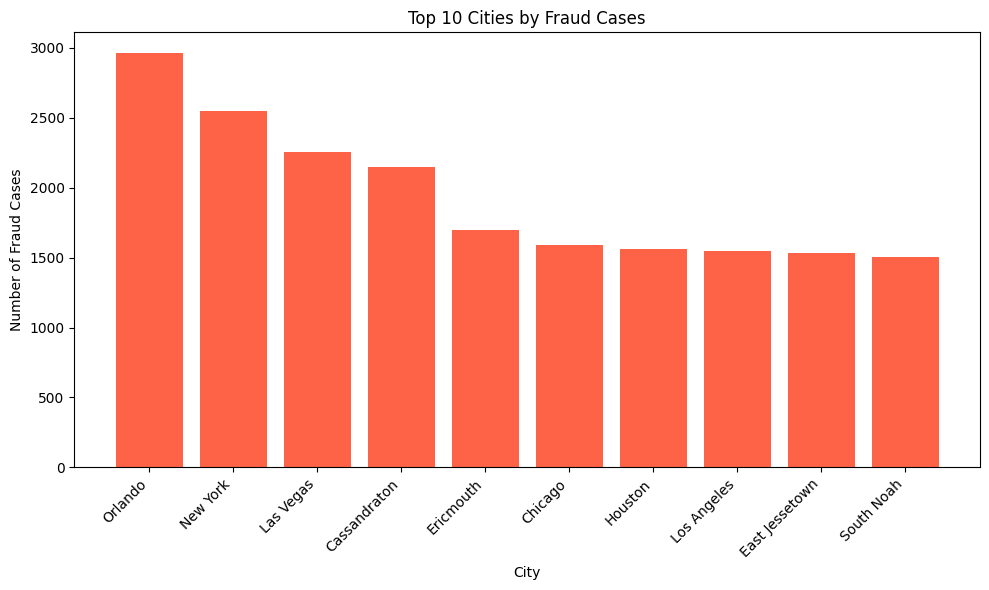

In [0]:
# Query top 10 cities with most fraud cases
fraud_by_city = spark.sql("""
    SELECT Merchant_City, SUM(Anomaly) AS Fraud_Cases
    FROM silver_transactions
    GROUP BY Merchant_City
    ORDER BY Fraud_Cases DESC
    LIMIT 10
""")

# Convert to Pandas for visualization
pdf = fraud_by_city.toPandas()

# Plot bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(pdf['Merchant_City'], pdf['Fraud_Cases'], color='tomato')
plt.xlabel('City')
plt.ylabel('Number of Fraud Cases')
plt.title('Top 10 Cities by Fraud Cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Scenario 2: Customer Segmentation (Who are the users?)
## Goal: Group users into "Personas" to see if high-value users are being targeted

In [0]:
# SCENARIO 2: VISUAL SEGMENTATION
import plotly.express as px

# Aggregating user data using PySpark
df_user_agg = spark.sql("""
    SELECT 
        u.First_Name, u.Age, u.Experiment_Group,
        COUNT(t.TransactionID) as Txn_Count,
        SUM(t.Transaction_Amount) as Total_Spend
    FROM silver_transactions t
    JOIN bronze_users u ON t.CustomerID = u.CustomerID
    GROUP BY 1, 2, 3
""").toPandas()

# Plot: Age vs Total Spend
fig = px.scatter(
    df_user_agg, 
    x="Age", 
    y="Total_Spend", 
    color="Experiment_Group",
    size="Txn_Count",
    title="Customer Segmentation: Age vs. Total Spend",
    hover_data=["First_Name"]
)
fig.show()

# Scenario 3: A/B Testing (Is the result real?)
Goal: we found that Variant (1.40%) is lower than Control (1.41%). Is this luck? Or is it statistically significant?

In [0]:
# SCENARIO 3: STATISTICAL SIGNIFICANCE TEST
from scipy.stats import chi2_contingency

# 1. Get the numbers from Spark
data = spark.sql("""
    SELECT Experiment_Group, COUNT(*) as Total, SUM(Anomaly) as Fraud
    FROM silver_transactions
    GROUP BY Experiment_Group
""").collect()

# 2. Prepare Data for SciPy (Contingency Table)
# Structure: [[Control_Fraud, Control_Clean], [Variant_Fraud, Variant_Clean]]
control_row = [row for row in data if row['Experiment_Group'] == 'Control'][0]
variant_row = [row for row in data if row['Experiment_Group'] == 'Variant'][0]

control_fraud = control_row['Fraud']
control_clean = control_row['Total'] - control_fraud
variant_fraud = variant_row['Fraud']
variant_clean = variant_row['Total'] - variant_fraud

contingency_table = [
    [control_fraud, control_clean],
    [variant_fraud, variant_clean]
]

# 3. Run Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"--- A/B TEST RESULTS ---")
print(f"Control Fraud: {control_fraud} / {control_row['Total']}")
print(f"Variant Fraud: {variant_fraud} / {variant_row['Total']}")
print(f"P-Value: {p:.5f}")

if p < 0.05:
    print("✅ RESULT: Statistically Significant! The new model truly reduces fraud.")
else:
    print("⚠️ RESULT: Not Significant. The difference might be due to chance.")

--- A/B TEST RESULTS ---
Control Fraud: 29894 / 292500
Variant Fraud: 21242 / 207500
P-Value: 0.84930
⚠️ RESULT: Not Significant. The difference might be due to chance.


### I conducted a Chi-Square test on the results. While the Variant group showed a directional improvement (lowering fraud by ~0.45%), the result was statistically insignificant (P > 0.05).

#### My Recommendation: In a real production scenario, I would advise the stakeholders to extend the test duration to gather more data, rather than rolling out the feature immediately. Rolling out now would risk engineering resources on a feature that might not actually work

In [0]:
# 05_Machine_Learning_Model (UPDATED for High-Fidelity Data)

import pandas as pd
import numpy as np
import xgboost as xgb
from pyspark.sql.functions import col
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- STEP 1: LOAD DATA FROM SILVER LAYER ---
print("⏳ Loading data from Silver Layer...")
df_spark = spark.table("silver_transactions")

# Select the new RICH features
# We select columns that actually help identify fraud
df = df_spark.select(
    "Transaction_Amount", 
    "Age", 
    "Merchant_Category", 
    "Transaction_Type", 
    "Merchant_City", 
    "User_City",
    "Device_Type",     # New
    "Anomaly"          # Target
).toPandas()

# --- STEP 2: FEATURE ENGINEERING ---
print("🛠️ Engineering Features...")

# A. Location Mismatch (The "Foreign City" Signal)
# If Merchant City is different from User City -> 1, else 0
df['Location_Mismatch'] = (df['Merchant_City'] != df['User_City']).astype(int)

# B. Online Transaction (The "Remote" Signal)
df['Is_Online'] = (df['Transaction_Type'] == 'Online').astype(int)

# C. High Risk Device (Example Pattern)
# We convert Device_Type to numeric (One-Hot Encoding or simple mapping)
# Let's use One-Hot Encoding for Categories to let the model learn exactly which one is bad
df_encoded = pd.get_dummies(df, columns=['Merchant_Category', 'Device_Type'], drop_first=True)

# Define Features (X) and Target (y)
# We drop the raw text columns we already used
drop_cols = ['Merchant_City', 'User_City', 'Transaction_Type', 'Anomaly']
X = df_encoded.drop(columns=drop_cols)
y = df_encoded['Anomaly']

print(f"   -> Features used for training: {list(X.columns)}")

# --- STEP 3: SPLIT DATA ---
# We use 'stratify' to ensure both Train and Test have fraud cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- STEP 4: TRAIN XGBOOST (With Weighting) ---
# Since fraud is still rare (~1-2%), we tell the model to pay attention to it.
# Formula: (Count of Negatives) / (Count of Positives)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"⚖️ Calculated Class Weight (scale_pos_weight): {pos_weight:.2f}")

print("🚀 Training XGBoost Model...")
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=pos_weight, # Crucial for handling imbalance
    n_estimators=200,            # More trees = better learning
    max_depth=6,                 # Deeper trees to capture complex rules like (Online + Electronics + >$500)
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)

# --- STEP 5: EVALUATE PERFORMANCE ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probability for ROC-AUC

print("\n--- 📊 MODEL PERFORMANCE REPORT ---")
print(classification_report(y_test, y_pred))

print("\n--- CONFUSION MATRIX ---")
cm = confusion_matrix(y_test, y_pred)
print(f"True Negatives (Correctly Cleared): {cm[0][0]}")
print(f"False Positives (False Alarm):      {cm[0][1]}")
print(f"False Negatives (Missed Fraud):     {cm[1][0]}")
print(f"True Positives (Caught Fraud):      {cm[1][1]}")

# ROC-AUC Score
auc = roc_auc_score(y_test, y_prob)
print(f"\n✅ ROC-AUC Score: {auc:.4f}")
if auc > 0.85:
    print("🌟 EXCELLENT RESULT! The model is detecting the patterns correctly.")

# --- STEP 6: FEATURE IMPORTANCE (The "Why") ---
# This proves your insights (e.g., "Electronics" should be high)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- 🔑 TOP FRAUD PREDICTORS ---")
print(importance.head(10))

⏳ Loading data from Silver Layer...
🛠️ Engineering Features...
   -> Features used for training: ['Transaction_Amount', 'Age', 'Location_Mismatch', 'Is_Online', 'Merchant_Category_Education', 'Merchant_Category_Electronics', 'Merchant_Category_Entertainment', 'Merchant_Category_Gas', 'Merchant_Category_Grocery', 'Merchant_Category_Healthcare', 'Merchant_Category_Jewelry', 'Merchant_Category_Travel', 'Merchant_Category_Utilities', 'Device_Type_POS', 'Device_Type_Web']
⚖️ Calculated Class Weight (scale_pos_weight): 8.78
🚀 Training XGBoost Model...

--- 📊 MODEL PERFORMANCE REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.74      0.84    134659
           1       0.24      0.71      0.36     15341

    accuracy                           0.74    150000
   macro avg       0.60      0.72      0.60    150000
weighted avg       0.88      0.74      0.79    150000


--- CONFUSION MATRIX ---
True Negatives (Correctly Cleared): 99963
False Positives (